In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from lmfit.models import QuadraticModel, LorentzianModel
import math

def findarg(data, value):
    arg = 0
    for wl in data:
        if wl<value:
            arg = arg + 1
        else:
            return arg
        
    return arg

In [2]:
def integrate (wavelength, intensity, minWavelength, maxWavelength):
    sum = 0
    Index = list(range(findarg(wavelength, minWavelength),findarg(wavelength, maxWavelength)))
    for i in Index:
        sum += intensity[i]*(wavelength[i+1]-wavelength[i])
    return sum
        

In [3]:
def getRatio(data):

    #fit NV0


    model1 = QuadraticModel(prefix='bkg_') + LorentzianModel(prefix='r1_') + LorentzianModel(prefix='nv0_')
    # model1 =  LorentzianModel(prefix='r1_') + LorentzianModel(prefix='nv0_')
    model = model1
    params = model.make_params()
    nv0_peak = data['W'][375+np.argmax(data['I'][375:390])]

    params['r1_center'].set(value = 572.7, vary=True)
    params['r1_amplitude'].set(value=48000, min = 0, vary=True)
    params['r1_sigma'].set(value=0.25, vary=True)

    params['nv0_center'].set(value = nv0_peak, min = nv0_peak-0.5, max = nv0_peak+0.5, vary=True)
    params['nv0_amplitude'].set(value=47123, min = 0, vary=True)
    params['nv0_sigma'].set(value=0.3, max = 0.4, vary=True)

    params['bkg_a'].set(value = 0, vary= False)
    params['bkg_b'].set(value = 0, vary=False)
    params['bkg_c'].set(value = 0, vary=True)

  
    Index = list(range(358,400))
    weightList = 1/np.sqrt(data['I'][Index])
    result = model.fit(data['I'][Index], params, x=data['W'][Index], weights=weightList)
    comps = result.eval_components(x=data['W'][Index])
    nv0Center = result.params['nv0_center']
    nv0HWHM = result.params['nv0_sigma']
    nv0 = integrate(data['W'],comps['nv0_'],nv0Center - nv0HWHM*2, nv0Center + nv0HWHM*2)


    #fit NV-

    model2 = QuadraticModel(prefix='bkg_') + LorentzianModel(prefix='nvm_')
    model = model2
    params = model.make_params()
    nvm_peak = data['W'][1080+np.argmax(data['I'][1080:1110])]

    params['nvm_center'].set(value=nvm_peak, min = nvm_peak-0.5, max = nvm_peak + 0.5, vary=True)
    params['nvm_amplitude'].set(value=10000, min = 0, vary=True)
    params['nvm_sigma'].set(value=0.5, max = 1, vary=True)

    params['bkg_a'].set(value = 0, vary=True)
    params['bkg_b'].set(value = 0, vary=True)
    params['bkg_c'].set(value = 0, vary=True)

    Index = list(range(1000,1200))
    weightList = 1/np.sqrt(data['I'][Index])
    result = model.fit(data['I'][Index], params, x=data['W'][Index], weights=weightList)
    comps = result.eval_components(x=data['W'][Index])
    nvmCenter = result.params['nvm_center']
    nvmHWHM = result.params['nvm_sigma']
    nvm = integrate(data['W'],comps['nvm_'],nvmCenter - nvmHWHM*2, nvmCenter + nvmHWHM*2)

    return nvm/(nvm+nv0)

In [4]:
high = []
mid = []
low = []

for i in [3,6,9,12,15,18]:
    high.append(pd.read_csv('98-m3-'+ str(i) + '-2' + '.csv'))
    mid.append(pd.read_csv('98-m3-'+ str(i) + '-0p5' + '.csv'))
    low.append(pd.read_csv('98-m3-'+ str(i) + '-0p1' + '.csv'))
    



In [5]:
ratioHighPower = []
ratioMidPower = []
ratioLowPower = []


for data in high:
    ratioHighPower.append(getRatio(data))
for data in mid:
    ratioMidPower.append(getRatio(data))
for data in low:
    ratioLowPower.append(getRatio(data))


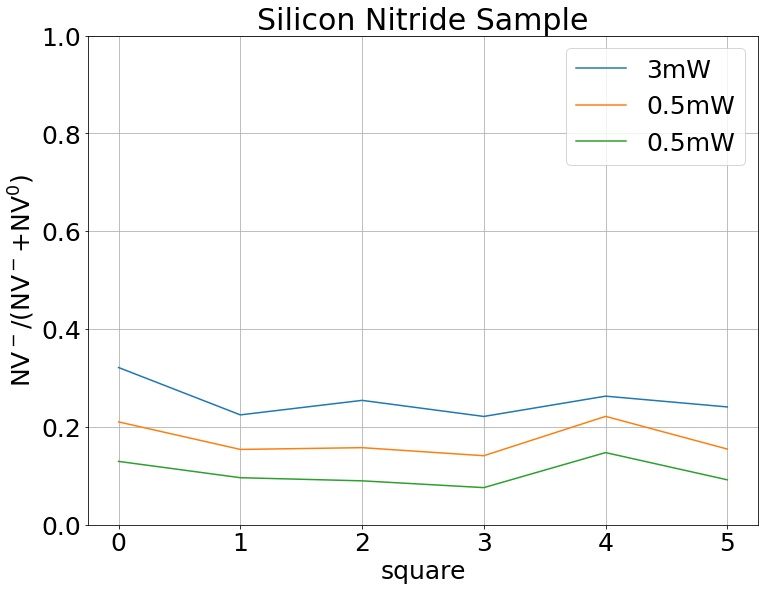

In [6]:
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(12,9))
plt.grid()
plt.xlabel('square')
plt.ylabel('NV$^-$/(NV$^-$+NV$^0$)')
plt.ylim(0,1)
plt.title('Silicon Nitride Sample')
plt.plot(ratioHighPower,label = '3mW')
plt.plot(ratioMidPower,label = '0.5mW')
plt.plot(ratioLowPower,label = '0.5mW')
plt.legend()


In [7]:

ratioLowPower[0]

0.12962098551735304